<a href="https://colab.research.google.com/github/Joykareko/AWS-Udacity-Capstone-Project/blob/main/Arvato_Project_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
! ls ../../data/Term2/capstone/arvato_data/

Udacity_AZDIAS_052018.csv     Udacity_MAILOUT_052018_TEST.csv
Udacity_CUSTOMERS_052018.csv  Udacity_MAILOUT_052018_TRAIN.csv


In [ ]:
! cp ../../data/Term2/capstone/arvato_data/* . -fv

'../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv' -> './Udacity_AZDIAS_052018.csv'
'../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv' -> './Udacity_CUSTOMERS_052018.csv'
'../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv' -> './Udacity_MAILOUT_052018_TEST.csv'
'../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv' -> './Udacity_MAILOUT_052018_TRAIN.csv'


In [ ]:
! zip all.zip * .csv

	zip warning: name not matched: .csv
  adding: Arvato Project Workbook.ipynb (deflated 68%)
  adding: Arvato-Project-Workbook-zh.ipynb (deflated 58%)
  adding: DIAS Attributes - Values 2017.xlsx (deflated 10%)
  adding: DIAS Information Levels - Attributes 2017.xlsx (deflated 15%)
  adding: Udacity_AZDIAS_052018.csv (deflated 78%)
  adding: Udacity_CUSTOMERS_052018.csv (deflated 81%)
  adding: Udacity_MAILOUT_052018_TEST.csv (deflated 79%)
  adding: Udacity_MAILOUT_052018_TRAIN.csv (deflated 79%)
  adding: terms_and_conditions/ (stored 0%)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [23]:
# load in the data
azdias = pd.read_csv('/content/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('/content/Udacity_CUSTOMERS_052018.csv', sep=';')
attributes = pd.read_excel('/content/DIAS Attributes - Values 2017.xlsx', header=1)
print('Data Loaded Successfully.......!')

Data Loaded Successfully.......!


### Checking out the General populations' data (Azdias)

In [ ]:
#checking out the data, first 3 rows
#The data has alot of missing values which will need cleanup
azdias.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6.0,3.0,6.0,6.0,7.0,3.0,5.0,5.0,5.0,4.0,7.0,2.0,3.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2.0,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,24,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1.0,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0


In [ ]:
#checking out the number of columns and rows
azdias.shape

(891221, 366)

In [ ]:
#checking out the general info on columns
#we have 6 columns that have categorical data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [ ]:
#checking out which columns are these
list(azdias.select_dtypes(include='object').columns)

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [ ]:
#lets check out the number of categories
#the dataset has 6 features that are categorical. Each feature has different categories, some with unknown values
azdias.select_dtypes(include='object').nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64

In [ ]:
#checking out stats features for the 360 numerical features
#the mean values are very varied. We may need to preprocess them before modelling.
#we also have alot of missing data.
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [ ]:
#number of unknown values in general
unknowns=azdias.isnull().sum().sum()
print('Total Unknown Values for the Population Dataset is: ',unknowns)

Total Unknown Values for the Population Dataset is:  16902223


These are alot of unknowns.
Lets check the data description to check on the categorical features further for azdias.

### Checking out the Attributes data/information

In [ ]:
attributes.head(2)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible


In [ ]:
attributes.tail(2)

,Unnamed: 0,Attribute,Description,Value,Meaning
2256,NaN,NaN,NaN,5,seeking orientation
2257,NaN,NaN,NaN,6,indifferent


The above data shows that there are missing values inform of (-1,0,9 and even 10)
Lets see exactly that below

In [ ]:
attributes[attributes.Meaning.str.contains('know',na=False)]

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown
48,NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,NaN,CJT_GESAMTTYP,customer journey typology,0,unknown
138,NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known


Thats alot of unknowns. We need to convert them to NaNs and then get a list of missing values afresh

Lets explore the customers data as well.

### Checking out the customers data characteristics

In [ ]:
#displaying 3 rows of customers dataset
customers.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


In [ ]:
customers.shape

(191652, 369)

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


We have 8 categorical type, features in the customers dataset

In [ ]:
#checking out which columns are these
list(customers.select_dtypes(include='object').columns)

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ',
 'PRODUCT_GROUP',
 'CUSTOMER_GROUP']

In [ ]:
#lets check out the number of categories
#the dataset has 6 features that are categorical. Each feature has different categories, some with unknown values
customers.select_dtypes(include='object').nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               3034
OST_WEST_KZ                    2
PRODUCT_GROUP                  3
CUSTOMER_GROUP                 2
dtype: int64

In [ ]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [ ]:
#number of unknown values in general
unknowns2=customers.isnull().sum().sum()
print('Total Unknown Values for the Customers Dataset is: ',unknowns2)

Total Unknown Values for the Customers Dataset is:  13864522


In [5]:
customers.CUSTOMER_GROUP.value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

### Cleaning the Datasets

After assessing the datasets, the below steps will be followed inorder to clean the datasets:

1. Drop all columns null/missing values with 30% missing data.
2. Replace missing values(-1/0/9/10/etc) through data imputation.
        a. Numerical features with Median (median value)
        b. Categorial features with Mode(most common)


In [26]:
#to accelerate the runtime, we will use a sample of the data.
population = azdias.sample(n=5000)
customers= customers.sample(n=5000)
print(population.shape,customers.shape)

(5000, 366) (5000, 369)


In [27]:
#label encoding
customers.replace({'PRODUCT_GROUP':{'COSMETIC':0,'FOOD':1,'COSMETIC_AND_FOOD':2},
                   'CUSTOMER_GROUP':{'MULTI_BUYER':0,'SINGLE_BUYER':1}
                   },inplace=True)

In [28]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 32826 to 14282
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(96), object(6)
memory usage: 14.1+ MB


In [9]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 11393 to 123188
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(289), int64(71), object(6)
memory usage: 14.0+ MB


In [29]:
def drop_cols(df):
    '''
    function that drops columns that 
    have more than 30% data that is missing/contains NaNs
    '''
    #finding columns with 30% missing data
    #print("==========================")
    print('Old Data shape: ',df.shape)
    
    df_1 = (df.isnull().sum()/df.shape[0])>0.3
    df_2 = df[df.columns[~df_1]]
    print('=============================')
    print("New Data shape: ", df_2.shape)
    print('=============================')
    
    return df_2

In [30]:
def identify_nas(attributes):
    '''
    function that shows which values are unknowns in the
    attributes dataframe
    '''
    df=attributes.copy()
    df = df[df.Meaning.str.contains('know',na=False)].reset_index(drop=True)
    
    s = df['Value'].str.split(',').apply(pd.Series, 1).stack() #splits the valaues in that column
    s.index = s.index.droplevel(1)
    s.name='New_value'
    df = df.join(s)  #joins with the new value
    df.loc[df.New_value.isna(),'New_value']=df[~df.Value.str.contains(',',na=False)].Value  #locates the values
    df.reset_index(drop=True,inplace=True)
    df['New_value']=df['New_value'].astype(float)
    
    return df

def unknown_nas(df,new_attributes):

  '''
    this function replaces all unknowns(-1,0,9,10) with NaN
    '''
  df_1 = df.copy()
  cols = df_1.columns.intersection(new_attributes.columns)
  for i in range(len(new_attributes[cols])):
    value = new_attributes.loc[i,'New_value']
    col = new_attributes.loc[0,'Attribute']
    mask = df_1[col] == value
    df_1[mask]= np.nan
        
    return df_1

In [31]:
#replacing all NaNs with median(numeical features) and Mode(categorical features)
#Median is preferable to mean due to skewness

def impute_nas(df,new_attributes):
    '''
    this function performs data imputation on the remaining dataset
    '''
    dt=new_attributes.copy()
    data=df.copy()
    
    dt=dt[dt.Meaning.str.contains('numeric',na=False)]

    print("Number of Nas before filling : {}".format(data.isnull().sum().sum()))
    # Numerical features => Median
    mask = dt.Attribute.values
    data[mask]= data[mask].fillna(data.median())
    print("Number of Nas after filling Numeric features : {}".format(data.isnull().sum().sum()))
    
    # Categorical features => Most frequent (Mode)
    mask = data.columns.difference(mask)
    data[mask]= data[mask].fillna(data.mode().iloc[0])
    print("Number of Nas after  filling All features: {}".format(data.isnull().sum().sum()))
    
    return data

In [32]:
#lets drop these columns that have too many categories
#lets also scale the numerical values

def encode_data(df,new_attributes):

    #label encoding
    

    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    df.fillna(0,inplace=True)

    # drop some features
    cols= ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','OST_WEST_KZ']
    df=df.drop(columns=cols,axis=1)

    # Scale numerical Numerical features
    scaler = StandardScaler()
    scaled_arr = scaler.fit_transform(df)
    data_scaled = pd.DataFrame(scaled_arr, columns = df.columns)
    df =data_scaled

    return df

In [33]:
#one last function to do all the work
def clean_data(data,attributes):
    '''
    Clean data from beginning to end
  
    '''
    # clean description data
    print("Cleaning attributes data ...")
    new_attributes = identify_nas(attributes)
    print('==============================')
    # delete Nas
    print("Deleting Nas columns ...")
    data = drop_cols(data)
    print('==============================')
    # replace Unknown by  Nas
    print("Replacing Unknowns by Nas ...")
    data = unknown_nas(data,new_attributes)
    print('==============================')
    # input nas
    print("Imputing data ...")
    data = impute_nas(data,new_attributes)
    print('==============================')
    # encode data
    print("Encoding data ...")
    data = encode_data(data,new_attributes)
    
    data.fillna(method='ffill',inplace=True)
    print('==============================')
    print('Final data size: ',data.shape)
    
    return data

In [15]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 11393 to 123188
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(289), int64(71), object(6)
memory usage: 14.0+ MB


In [16]:
encode_data(population,attributes)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.443750,-0.524585,-0.835842,1.256505,-0.297189,-0.176856,-0.08433,-0.037213,1.355829,-0.112264,-0.107322,-0.294408,-0.497604,-0.151298,-0.040032,0.858016,-1.121322,-1.348808,-1.087422,1.493193,0.476114,0.457768,1.286468,-0.204530,-0.912107,-0.924753,0.435809,-0.224707,-0.292769,0.424706,-0.450342,-0.351478,-0.13052,0.114131,0.366603,-0.233209,-0.276854,-0.30485,-0.503326,-0.29337,...,-0.728534,0.747043,-1.666662,1.280275,0.892287,-0.552597,-0.386327,-0.824646,1.427828,-1.830272,0.135893,1.549223,-0.665405,1.602307,0.990737,0.061087,0.876370,1.570261,0.764208,1.423909,-0.233706,-0.082744,0.671218,-0.022717,0.076397,0.872098,-0.293278,-0.381610,-0.226674,-0.352994,-0.076626,-0.785304,-0.513175,-0.475067,1.157291,-1.163286,-0.278543,1.214258,-1.030464,-0.732890
1,1.320059,-0.524585,-0.835842,-1.274985,-0.297189,-0.176856,-0.08433,-0.037213,0.693868,-0.323789,-0.107322,-0.294408,0.336463,-0.384472,-0.040032,-1.349193,1.366634,-0.663090,-0.446033,1.493193,-1.503844,-0.264719,-1.549661,0.503676,0.519098,0.499697,1.173469,-0.224707,-0.292769,0.424706,-0.450342,-0.351478,-0.13052,0.114131,0.366603,-0.233209,-0.276854,-0.30485,0.817740,-0.29337,...,-0.305214,-1.110041,-0.289142,0.571217,0.892287,0.681430,0.733138,1.419899,-0.674857,0.296715,1.238029,-1.620434,0.323456,-1.626632,-1.313839,-1.180522,-1.633569,0.031694,-1.546322,-0.025411,-0.233706,-0.082744,0.671218,-0.022717,1.371261,0.872098,-0.293278,-0.501553,-0.226674,0.617836,0.668765,-1.411494,-1.316853,-1.440389,0.253299,0.609151,1.539624,-1.765882,0.970437,1.146796
2,1.528139,-0.524585,-1.107802,-1.274985,-0.297189,-0.176856,-0.08433,-0.037213,-1.292016,-0.535315,-0.107322,-0.294408,-1.331671,-0.539921,-0.040032,-2.084929,-1.535981,-1.691667,-1.845427,-0.369573,-1.503844,1.180256,1.286468,-1.620943,-0.912107,-0.924753,-1.039510,-0.224707,-0.292769,0.424706,-0.450342,-0.351478,-0.13052,0.114131,0.366603,-0.233209,-0.276854,-0.30485,-0.503326,-0.29337,...,-1.575174,-1.729069,-1.666662,1.280275,0.139048,1.298443,0.733138,-0.824646,0.902157,0.828461,1.238029,-0.563882,0.323456,0.525994,0.414593,0.061087,1.378358,-0.994017,-0.391057,-1.474732,-1.801152,-0.082744,-2.177753,-0.022717,-1.865899,-2.196508,-0.293278,-0.501553,-2.363090,-0.352994,-1.567408,-1.724589,-1.852639,-1.762163,-1.554686,-2.581235,-1.642169,-0.275812,0.970437,0.206953
3,-0.811953,-0.524585,-1.107802,-1.274985,-0.297189,-0.176856,-0.08433,-0.037213,-1.292016,-0.535315,-0.107322,-0.294408,-1.331671,-0.539921,-0.040032,-2.084929,-1.535981,-1.691667,-1.845427,0.251349,-1.503844,0.457768,-0.131596,-0.204530,-0.196504,0.499697,0.435809,-0.224707,-0.292769,0.424706,-0.450342,-0.351478,-0.13052,0.114131,0.366603,-0.233209,-0.276854,-0.30485,-0.503326,-0.29337,...,-1.575174,-1.729069,-0.977902,-0.846899,-1.367430,0.064416,0.733138,-0.824646,0.902157,0.828461,1.238029,-0.563882,0.323456,0.525994,0.414593,0.061087,1.378358,-0.994017,-0.391057,-1.474732,-1.801152,-0.082744,-2.177753,-0.022717,-1.865899

In [34]:
#lets now clean and encode  our data
population = clean_data(population, attributes)
customers = clean_data(customers,attributes)

Cleaning attributes data ...
Deleting Nas columns ...
Old Data shape:  (5000, 366)
New Data shape:  (5000, 360)
Replacing Unknowns by Nas ...
Imputing data ...
Number of Nas before filling : 1391490
Number of Nas after filling Numeric features : 1391490
Number of Nas after  filling All features: 0
Encoding data ...
Final data size:  (5000, 356)
Cleaning attributes data ...
Deleting Nas columns ...
Old Data shape:  (5000, 369)
New Data shape:  (5000, 363)
Replacing Unknowns by Nas ...
Imputing data ...
Number of Nas before filling : 911214
Number of Nas after filling Numeric features : 911214
Number of Nas after  filling All features: 0
Encoding data ...
Final data size:  (5000, 359)


In [19]:
encode_data(customers,attributes)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.491404,-0.956281,-0.179943,0.746703,-0.234934,-0.157579,-0.075068,-0.019994,-1.287579,-0.235274,-0.123058,-0.234699,-0.454015,-0.224336,-0.118411,-0.036862,1.451217,-0.777457,-0.486473,-0.875837,0.717588,0.233065,-0.943645,-0.407960,-0.275881,-0.390352,-0.409528,-0.213993,-0.263553,0.375533,-0.347012,-0.276388,-0.130072,0.169518,0.279245,-0.189776,-0.274398,-0.467047,-0.589396,-0.442597,...,-1.052076,-1.267047,1.917330,-2.181780,-0.804710,-0.219961,-1.156196,-0.822509,0.204904,-0.243250,0.039709,-0.351054,-0.137325,-0.549782,1.316955,0.880783,0.780228,-0.635531,-0.095298,0.863996,-0.086404,-0.113470,0.389187,-0.259738,2.456631,0.132708,-0.538244,0.176196,1.189888,2.050097,2.775047,0.788917,0.640860,1.733619,-1.367063,0.860446,-0.659958,-0.319452,-0.788875,0.868940
1,1.320928,0.474421,-0.179943,1.707957,-0.234934,-0.157579,-0.075068,-0.019994,0.086205,-0.143827,-0.123058,-0.234699,4.050104,-0.128359,-0.118411,1.284347,1.451217,1.015571,1.246476,0.738708,-1.315239,-1.032903,-0.943645,0.534646,0.568308,0.527259,0.510346,4.821139,3.195152,-5.246219,1.431927,1.927664,-0.130072,0.169518,-6.404821,5.298253,-0.274398,-0.467047,1.773544,0.468283,...,-0.314502,0.505543,-0.592264,-0.941357,-0.804710,0.941396,-1.685590,-1.804141,0.204904,1.131042,1.130620,0.316603,-1.633244,0.418997,1.316955,0.880783,1.206349,-0.635531,-0.095298,0.863996,-0.086404,0.469024,0.389187,-0.259738,1.002673,0.132708,1.948255,0.176196,-0.399766,-0.757571,-0.159027,-0.404122,0.640860,0.507291,-1.367063,0.860446,-0.659958,-0.319452,-0.788875,0.868940
2,-0.951491,0.474421,-0.179943,1.021347,4.438367,-0.157579,-0.075068,-0.019994,0.429651,-0.235274,-0.123058,2.199934,1.476322,-0.224336,-0.118411,-0.036862,1.451217,-0.060246,0.148941,-0.337655,-0.637630,-0.399919,-0.943645,0.534646,0.568308,0.527259,0.510346,-0.213993,-0.263553,0.375533,-0.347012,-0.276388,-0.130072,0.169518,0.279245,-0.189776,-0.274398,-0.467047,-0.195573,-0.442597,...,0.423072,-3.039637,0.035134,0.919277,1.555490,-0.800639,0.431985,-0.331693,-1.078153,-0.243250,-1.051202,-1.018710,-0.137325,-1.034171,0.147264,0.076268,-0.072014,1.307592,-0.095298,-0.678854,-0.086404,1.634012,0.868836,-0.259738,-0.451284,0.132708,2.777088,0.857016,-0.717697,-0.757571,-0.578180,-0.801802,0.640860,1.733619,-1.367063,-0.358661,1.515249,-0.319452,1.267629,0.868940
3,1.238024,-0.956281,-0.179943,-1.175807,-0.234934,-0.157579,-0.075068,-0.019994,-1.287579,0.953531,-0.123058,-0.234699,-1.097461,1.119338,-0.118411,0.623743,1.451217,1.374176,1.362006,-0.875837,0.717588,-1.032903,-0.943645,0.534646,0.568308,0.527259,0.510346,-0.213993,-0.263553,0.375533,-0.347012,-0.276388,-0.130072,0.169518,0.279245,-0.189776,-0.274398,-0.467047,-0.589396,-0.442597,...,0.423072,0.505543,-0.592264,-0.941357,1.555490,0.941396,-1.156196,-0.822509,0.204904,1.131042,1.130620,0.316603,-0.137325,-0.549782,1.316955,0.880783,1.206349,1.307592,-0.095298,0.092571,-0.086404,-0.113470,-0.570111,-0.259738,-0.451284,0.1

In [35]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 359 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(359)
memory usage: 13.7 MB


In [36]:
customers.select_dtypes(include='object').nunique()

Series([], dtype: float64)

In [37]:
population.select_dtypes(include='object').nunique()

Series([], dtype: float64)

Now, our data is clean, and standardized, lets do some visualizations

## Exploratory Data Analysis

Our data is clean, lets check out some variable characteristics

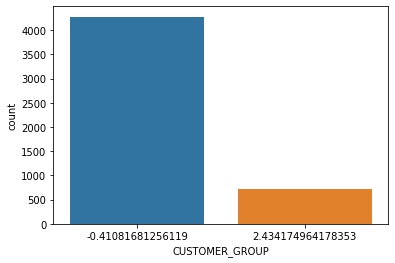

In [42]:
#there are 2 types of buyers. Single buyers and multiple buyers
sns.countplot(customers.CUSTOMER_GROUP)


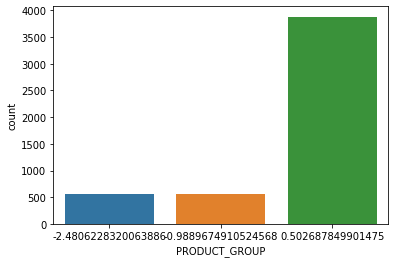

In [43]:
sns.countplot(customers.PRODUCT_GROUP)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

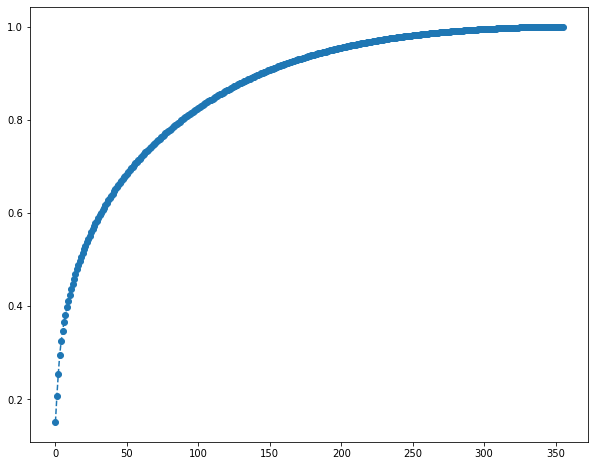

In [44]:
#obtaining the best features
pca = PCA() # init pca
pca.fit(population) # fit the dataset into pca model

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
cumulativeValue = pca.explained_variance_ratio_.cumsum()

#we can plot the cumulative value as below
plt.figure(figsize= (10, 8)) # size of the chart(size of the vectors)
plt.plot(ind, cumulativeValue, marker = 'o', linestyle="--");

In [46]:
#obtaining columns that have explain 80% variance in the population dataset
df= pd.DataFrame(cumulativeValue,columns=["cum_variance"])
mask=df.cum_variance > 0.80
k=df[mask].index[0]

print('Columns that explain 80% variance are: ',k)

Columns that explain 80% variance are:  89


In [48]:
pca = PCA(n_components=89)
newpop_data = pca.fit_transform(population)
print('New Population Data after PCA has: ',newpop_data.shape)

New Population Data after PCA has:  (5000, 89)


In [60]:
pca = PCA(n_components=89) # init pca
newcust_data=pca.fit_transform(customers) # fit the dataset into pca model


We have fit the number of customers and population using PCA best features. Now, lets obtain and then visualize the clusters

In [50]:
#choosing the clusters
#using Within Cluster Sum of Squares (WCSS)
#finding wcss value for different number of clusters
wcss = []
for i in range(1,20):
  kmeans = KMeans(n_clusters = i, init = 'k-means++',random_state=42)
  kmeans.fit(newpop_data)
  wcss.append(kmeans.inertia_)

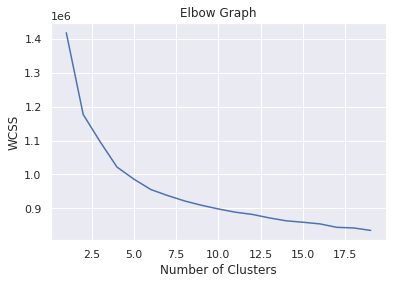

In [52]:
#plotting the elbow graph
sns.set()
plt.plot(range(1,20),wcss)
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [63]:
#training the kmeans clustering model
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
#return a label for each data point based on each cluster
Y = kmeans.fit_predict(newpop_data)
print(Y)

Z= kmeans.fit_predict(newcust_data)
print(Z)

[1 1 9 ... 1 5 1]
[4 2 8 ... 5 1 2]


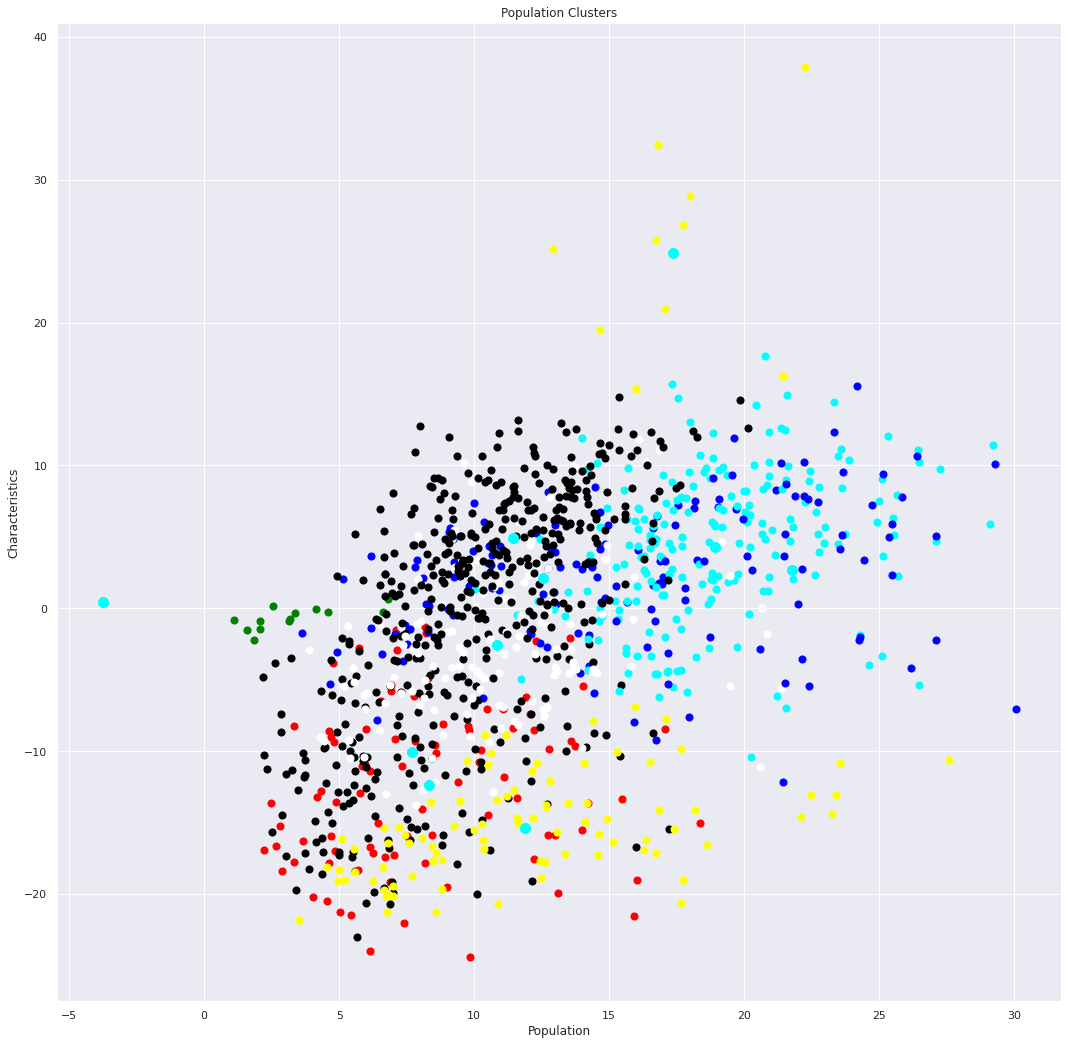

In [58]:
#visualizing the clusters
#plotting the 10 centroids and their clusters
plt.figure(figsize=(18,18))
plt.scatter(newpop_data[Y==0,0],newpop_data[Y==0,1],s=50,c= 'red',label = 'Cluster 1')
plt.scatter(newpop_data[Y==1,0],newpop_data[Y==1,1],s=50,c= 'green',label = 'Cluster 2')
plt.scatter(newpop_data[Y==2,0],newpop_data[Y==2,1],s=50,c= 'blue',label = 'Cluster 3')
plt.scatter(newpop_data[Y==3,0],newpop_data[Y==3,1],s=50,c= 'yellow',label = 'Cluster 4')
plt.scatter(newpop_data[Y==4,0],newpop_data[Y==4,1],s=50,c= 'black',label = 'Cluster 5')

plt.scatter(newpop_data[Y==5,0],newpop_data[Y==5,1],s=50,c= 'cyan',label = 'Cluster 6')
plt.scatter(newpop_data[Y==6,0],newpop_data[Y==6,1],s=50,c= 'white',label = 'Cluster 7')
plt.scatter(newpop_data[Y==7,0],newpop_data[Y==7,1],s=50,c= 'blue',label = 'Cluster 8')
plt.scatter(newpop_data[Y==8,0],newpop_data[Y==8,1],s=50,c= 'yellow',label = 'Cluster 9')
plt.scatter(newpop_data[Y==9,0],newpop_data[Y==9,1],s=50,c= 'black',label = 'Cluster 10')

#plotting the centroids
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s= 100, c = 'cyan', label = 'Centroids')

plt.title('Population Clusters')
plt.xlabel('Population')
plt.ylabel('Characteristics')

plt.show()

In [64]:
# lets check out the clusters
cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(Y).value_counts().sort_index()
cluster_info["Customers"] = pd.Series(Z).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [65]:
cluster_info

,Cluster,Population,Customers
0,0,91,164
1,1,3849,347
2,2,96,2452
3,3,10,395
4,4,179,332
5,5,205,229
6,6,138,14
7,7,52,122
8,8,87,518
9,9,293,427


In [66]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(0)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(0)

In [67]:
cluster_info

,Cluster,Population,Customers,Pop_proportion,Cust_proportion
0,0,91,164,2.0,3.0
1,1,3849,347,77.0,7.0
2,2,96,2452,2.0,49.0
3,3,10,395,0.0,8.0
4,4,179,332,4.0,7.0
5,5,205,229,4.0,5.0
6,6,138,14,3.0,0.0
7,7,52,122,1.0,2.0
8,8,87,518,2.0,10.0
9,9,293,427,6.0,9.0


The above intel shows that, customers are mostly in clusters 2,8,9,4,1
However,potential customers will be coming from clusters 1,9,4,5,6.
This is because there are alot more people in the population in these clusters.

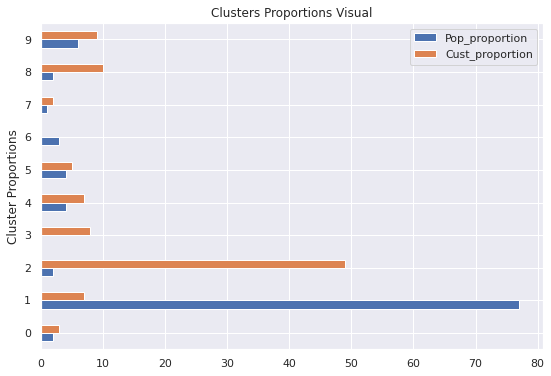

In [71]:
cluster_info.plot(x='Cluster', y = ['Pop_proportion', 'Cust_proportion'], kind='barh', figsize=(9,6))
plt.title('Clusters Proportions Visual')
plt.ylabel('Cluster Proportions')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [72]:
mailout_train = pd.read_csv('/content/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [73]:
mailout_train.shape

(42962, 367)

In [74]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,34716.000000,35993.000000,35993.000000,35185.000000,35993.000000,35011.000000,35163.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.00000,42357.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,35378.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,...,35011.000000,42357.000000,42357.000000,42357.000000,36582.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,35993.000000,35007.000000,35993.000000,35037.000000,35037.000000,35993.000000,35007.000000,42962.000000,35993.000000,34517.000000,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,0.049574,0.088990,2.017087,6.275856,0.009585,3.045214,4.256776,3.314234,3.896239,2.541020,2.313502,4.473074,4.377151,4.46500,4.424582,0.101718,0.176063,9.352777,0.702830,0.463363,0.104395,9.851799,9.579698,0.437419,0.376053,0.825474,1.655114,1.017201,0.636586,2.526721,...,2.958099,3.728593,2.484808,4.143046,2.201903,4.732973,5.115893,3.762558,4.665495,5.005982,3.166659,5.399213,3.417183,3.345724,3.196266,3.471789,3.624855,2.785555,3.886621,1.307365,0.009669,2.478019,0.007918,2.864829,4.268573,0.071264,4.465993,1.051930,1.137443,2.384738,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,0.380335,0.395995,1.358096,14.326333,0.104587,1.036404,2.195306,1.775397,1.442274,1.354576,1.394951,0.926475,1.063100,0.94503,0.981079,0.454065,0.632858,1.630259,1.818202,1.488133,0.794097,0.821226,1.359768,2.029658,1.416898,1.962661,2.634218,2.232345,1.875461,2.837579,...,1.347245,1.179454,1.232905,1.201550,1.306470,1.556256,1.824981,1.844612,1.723421,1.866681,1.664365,1.523510,1.806958,1.570618,1.278979,2.096219,1.677946,1.338823,2.103138,1.472973,0.097854,0.790463,0.128331,1.295502,0.993022,0.257269,8.460628,1.040342,1.553995,1.148251,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [75]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [76]:
newmail_data=clean_data(mailout_train,attributes)

Cleaning attributes data ...
Deleting Nas columns ...
Old Data shape:  (42962, 367)
New Data shape:  (42962, 361)
Replacing Unknowns by Nas ...
Imputing data ...
Number of Nas before filling : 6671515
Number of Nas after filling Numeric features : 6671515
Number of Nas after  filling All features: 0
Encoding data ...
Final data size:  (42962, 357)


In [77]:
newmail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 357 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(357)
memory usage: 117.0 MB


In [91]:
newmail_data.RESPONSE.value_counts()

-0.089843     42618
 11.130568      344
Name: RESPONSE, dtype: int64

In [101]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(newmail_data.RESPONSE)

LabelEncoder()

In [102]:
le.classes_

array([-0.08984268, 11.13056759])

In [103]:
le.transform

<bound method LabelEncoder.transform of LabelEncoder()>

In [104]:
newmail_data.RESPONSE.value_counts()

-0.089843     42618
 11.130568      344
Name: RESPONSE, dtype: int64

Our mailout data is now clean. Lets get to the modelling.

In [114]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
Y_encoded = lab_enc.fit_transform(newmail_data.RESPONSE)
print(utils.multiclass.type_of_target(newmail_data.RESPONSE))
print(utils.multiclass.type_of_target(newmail_data.RESPONSE.astype('int')))
print(utils.multiclass.type_of_target(Y_encoded))


continuous
binary
binary


In [115]:
X = newmail_data.drop(['RESPONSE'], axis=1)
Y = Y_encoded
print(X.shape,Y.shape)

(42962, 356) (42962,)


In [116]:
#splitting the data
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = .1, stratify = Y, random_state = 2)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(38665, 356) (4297, 356) (38665,) (4297,)


In [145]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from timeit import timeit
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [129]:
%%time
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [5,10,25,50,100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, Y_train)

CPU times: user 1min 56s, sys: 164 ms, total: 1min 56s
Wall time: 1min 55s


In [130]:
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)

{'n_estimators': 10}


In [120]:
%%time
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [121]:
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)

{'n_neighbors': 4}


In [131]:
%%time
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, Y_train)

CPU times: user 4.25 s, sys: 530 ms, total: 4.78 s
Wall time: 2.5 s


In [132]:
#test the three models with the test data and print their accuracy scores
print('knn: {}'.format(knn_best.score(X_test, Y_test)))
print('rf: {}'.format(rf_best.score(X_test, Y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, Y_test)))

knn: 0.9920875029090063
rf: 0.9920875029090063
log_reg: 0.99185478240633


In [133]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [135]:
%%time
#fit model to training data
ensemble.fit(X_train, Y_train)
#test our model on the test data
print(ensemble.score(X_test, Y_test))

0.9920875029090063
CPU times: user 14.2 s, sys: 790 ms, total: 15 s
Wall time: 9.39 s


In [139]:
Y_pred=ensemble.predict(X_test)

In [140]:
 confusion_matrix(Y_test, Y_pred)

array([[4263,    0],
       [  34,    0]])

There is a chance the model is overfitting due to the imbalance present between the response labels.Lets have a look at the roc score

In [143]:
roc=roc_auc_score(Y_test, log_reg.predict_proba(X_test)[:,1])
roc

0.7526596845634805

Lets plot and see how exactly the curve looks

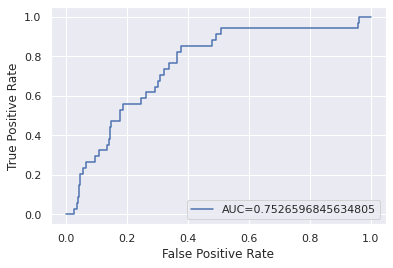

In [146]:
Y_pred_proba = log_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The closer AUC is to 1, the better the model. A model with an AUC equal to 0.5 is no better than a model that makes random classifications.
Our model has an AUC of 0.75, which makes it a good classifier.

## Part 3 : Kaggle Submission

In [147]:
mailout_test = pd.read_csv('/content/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [148]:
mailout_test.shape

(42962, 367)

In [180]:
mailout_test.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3


In [150]:
newmailout_test=clean_data(mailout_test,attributes)

Cleaning attributes data ...
Deleting Nas columns ...
Old Data shape:  (42962, 367)
New Data shape:  (42962, 361)
Replacing Unknowns by Nas ...
Imputing data ...
Number of Nas before filling : 6671515
Number of Nas after filling Numeric features : 6671515
Number of Nas after  filling All features: 0
Encoding data ...
Final data size:  (42962, 357)


In [153]:
newmailout_test.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,...,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04
mean,-2.500418e-16,8.207877e-16,-3.634347e-15,-7.767452e-16,1.045976e-15,-4.523554e-16,7.152691e-16,-7.615837e-16,5.005462e-16,-1.477055e-15,7.320896e-16,-6.436125e-16,-1.164786e-15,-1.802364e-15,1.307346e-17,2.353054e-16,4.264017e-16,-2.483582e-16,1.528760e-16,2.605099e-15,-1.288641e-15,1.311699e-15,7.123987e-16,1.319431e-15,-1.153497e-15,-7.769494e-16,5.236360e-17,-9.078939e-16,-7.390502e-16,5.192299e-17,-7.504039e-16,3.646342e-16,1.696258e-15,1.421776e-15,-2.886280e-15,1.442765e-15,-2.638267e-15,-1.862429e-15,1.482154e-16,-2.597610e-16,...,-8.610882e-16,1.358513e-16,1.047944e-16,1.005002e-15,-1.045463e-16,1.633420e-16,9.618022e-16,4.037757e-16,4.619712e-16,-9.112915e-17,-5.208948e-16,5.449634e-16,-5.997975e-16,2.015002e-16,-2.834303e-16,-1.884930e-16,8.635924e-16,-4.301914e-17,-2.985394e-18,8.890674e-16,6.307652e-16,2.608386e-16,-6.153230e-16,3.332271e-16,2.815321e-15,1.168379e-15,1.644777e-15,-7.770217e-16,4.446216e-15,8.305689e-16,5.141985e-16,-2.065704e-16,-3.269010e-17,-1.364456e-15,2.565902e-16,1.806168e-15,1.634659e-15,-1.576789e-15,5.285149e-16,1.616943e-15
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+0

In [155]:
newmailout_test.drop(columns=['LNR'],inplace=True)

In [173]:
kaggle_predict = log_reg.predict(newmailout_test)

In [170]:
print(kaggle_predict)

[0 0 0 ... 0 0 0]


In [174]:
submission_kaggle = pd.DataFrame()

In [175]:
submission_kaggle['LNR']= mailout_test.loc[newmailout_test.index,'LNR']

In [176]:
submission_kaggle['RESPONSE']=kaggle_predict

In [177]:
submission_kaggle.shape

(42962, 2)

In [178]:
submission_kaggle.head(2)

,LNR,RESPONSE
0,1763,0
1,1771,0


In [179]:
submission_kaggle.to_csv('kaggle_submission.csv', index=False)

## Conclusion

This project was an excellent opportunity for me to use a real world use case.
Cleaning the data, training the data as well as creating clusters around population characteristics was an excellent way for me to better my Data Science Skills.

A few things standout:
1. The models performed reasonably well considering the data imbalance.
2. I had to transform the data several times including label encoding for binary classification of the 'Response' variable/faeuture.
3. An ROC/AUC score of 0.75 meant the model was good.
4. More classification can be done using LGBM, XGBoost and other methods of classification.